# Experimental environment setup

## Library preparation

In [5]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
import time, os, io
from PIL import ImageGrab
from IPython.display import Image, display
import clipboard
from scipy import stats
from si_prefix import si_format
from tqdm import tqdm, tqdm_notebook

import pandas as pd
import numpy as np
from io import StringIO 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.close('all')

import sys 
sys.path.append('..')
from meas_util import *

import qcodes as qc
from qcodes import Station, load_by_run_spec, load_by_guid
from qcodes.instrument.base import Instrument
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
from qcodes.dataset.data_set import load_by_id
# from qcodes.dataset.data_export import get_shaped_data_by_runidb

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'


In [3]:
from qcodes.instrument_drivers.Lakeshore.Model_372 import Model_372
from qcodes.instrument_drivers.tektronix.AWG3252_Isrc import AWG3252_Isrc
from qcodes.instrument_drivers.HP.HP34401 import HP34401
from qcodes.instrument_drivers.HP.HP34401_DL1201 import HP34401_DL1201
from qcodes.instrument_drivers.Keithley.Keithley_2600_channels import *
from qcodes.instrument_drivers.tektronix.AWG5204_Isrc import AWG5204_Isrc

In [4]:
# #This code saves the image sources in clipboard into png file and copy a short PY code back into clipboard to display the specific png file. 

# import time, os
# dir_path = os.getcwd()
# pngpath = dir_path+"\\img\\{}{}{}-{}{}{}.png".format(time.localtime()[0]%100,time.localtime()[1],time.localtime()[2],time.localtime()[3],time.localtime()[4],time.localtime()[5])

# from PIL import ImageGrab
# img = ImageGrab.grabclipboard()
# img.save(pngpath, 'PNG')

# from IPython.display import Image, display
# display(Image(filename=pngpath))

# import clipboard
# clipboard.copy('display(Image(filename=r\'{}\'))'.format(pngpath))

In [ ]:
# display(Image(filename=r'C:\Users\KelvinOX25\Documents\GitHub\measDC\55B1_revist 1D chain\img\19113-124446.png'))

## Instrument nicknames and QC database initialization

In [4]:
try:
   Instrument.close_all()
except KeyError:
   pass    
except NameError:
   pass 

K2602 =  Keithley_2600(name = 'K2602', address = "GPIB::26::INSTR" )
Flux_chA = K2602.smua.curr
Flux_chB = K2602.smub.curr
Bfield =  Flux_chA
Bfield.step = .1e-3
Bfield.inter_delay = .1

LS370 = Model_372(name = 'LS370 input Ch', address = 'GPIB::12::INSTR', terminator='\n')
T8 = LS370.ch08.temperature

# htr = LS370.sample_heater
htr = LS370htr()
htr.Tset(0.030)
htr.PIDset(30,5,1)
htr.HTRset('off')

# Isrc = AWG5204_Isrc('gen', 'TCPIP0::AWG52000-XXXX::inst0::INSTR', ch = 1, R_bias = 1e9, Attn = 1, timeout = 20)
Isrc = AWG3252_Isrc('gen', 'TCPIP0::192.168.13.32::inst0::INSTR',  R_bias = 1e9, Attn = 1)
Isrc.init()

Vmeter = HP34401_DL1201('meter', 'GPIB0::8::INSTR', Gain = 100)
Vmeter.init('fast 6')

station = qc.Station(Isrc, Vmeter)

print ('Instrument initialization completed.')

Connected to: Keithley Instruments Inc. 2602A (serial:1272049, firmware:2.1.5) in 0.32s
Connected to: LSCI 370 (serial:370665, firmware:04102008) in 0.09s
initialization \\JOSH-PC\Gersh_Labview\DC measurement\LSCI 370 PYTHON_conf.vi
Instrument initialization completed.


In [5]:
SAMPLE = 'aka5B'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)   
initialise_database()

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|██████████████| 1/1 [00:00<00:00, 52.63it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|██████████████| 1/1 [00:00<00:00, 55.55it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v7 -> v8: 100%|██████████████| 1/1 [00:00<00:00, 55.55it/s]


## Fridge handling log

In [ ]:
# action = 'User: wsLu. Sample: {}. Roughing'.format(SAMPLE)
# action = 'ON Turbo @P1 = 6.47E-2'
# action = 'ON PT @P1 = 8.26E-4. ON HS-STILL, HS-MC'
# action = 'Test Cyro eff., t1hr @P1 = 3.51E-6'
# action = 'Add exchange gas thru v3'
# action = 'Pump coldtrap to P6 = 1.89E-1'
# action = 'Start Pulse_PreCool @T8 = 11.56K'
# action = 'Start Condense_wLN2'
action = 'base T'
# action = 'Warm up to RT'

Tlst = [48, 3.7, 0.661, 0.030, 0.80]
# Tlst = ['dont care']
flow = '0.20'
stillOut = '0'

tAbrStr = time.asctime()
actionStr = '\n\t'+action+'\n'
TPstr = '\tT[1,2,5,6,8]:\t{}\n'.format(Tlst)
misc = '\tFlow = {}, \tStill = {}%\n\n'.format(flow, stillOut)
clipboard.copy(tAbrStr+actionStr+TPstr+misc)

T8.get()

Tue Nov  19 17:00:00 2019
    Start Condense_wLN2 @T8 = 12K

Tue Nov  19 14:50:42 2019
    Start Pulse_PreCool @T8 = 5K

Tue Nov  19 14:00:00 2019
    ON PT, close all valves and cool back down

Tue Nov  19 13:10:42 2019
    Warm up by OFF PT, ON HS-STILL and ON HS-MC

Tue Nov  19 10:40:42 2019
    Start Condense_wLN2 @T8 = 12K

Tue Nov  19 08:40:42 2019
    Start Pulse_PreCool @T8 = 7.72K

Tue Nov  19 07:25:42 2019
    Warm up by OFF PT, ON HS-STILL and ON HS-MC
	T[1,2,5,6,8]:	[494, 3.7, 0.850, 0.030, ??]
	Flow = 0.00, 	Still = 0%

Mon Nov  18 19:44:00 2019
    Start Pulse_PreCool @T8 = 3.6K
    T[1,2,5,6,8]:	[85, 5, 6, 3.2, 3.6]
	Flow = 0.00, 	Still = 0%

Mon Nov  18 19:34:00 2019
    ON PT, close all valves and cool back down
    T[1,2,5,6,8]:	[87, 16.5, 14.2, 3.2, 3.4]
	Flow = 0.00, 	Still = 0%

Mon Nov  18 18:50:00 2019
    Warm up by OFF PT, ON HS-STILL and ON HS-MC
    T[1,2,5,6,8]:	[52, 3.9, 0.481, 0.735, 0.778]
	Flow = 0.00, 	Still = 0%

Mon Nov  18 15:52:00 2019
    Start Condense_wLN2 @T8 = 13.7K
    T[1,2,5,6,8]:	[61, 5.4, 7.8, 10, 13.7]
	Flow = 0.40, 	Still = 0%

Mon Nov  18 13:51:00 2019
    Start Pulse_PreCool @T8 = 4.9K
    T[1,2,5,6,8]:	[86, 6, 6, 3.25, 3.0]
	Flow = 0.00, 	Still = 0%

Mon Nov  18 13:43:00 2019
    ON PT, close all valves and cool back down
    T[1,2,5,6,8]:	[88, 16.8, 14.8, 5.25, 5.9]
	Flow = 0.00, 	Still = 0%

Mon Nov  18 12:55:00 2019
    Warm up by OFF PT, ON HS-STILL and ON HS-MC
    T[1,2,5,6,8]:	[54.5, 3.9, 0.950, 0.950, 1.2]
	Flow = 0.16, 	Still = 0%

Mon Nov  18 10:30:00 2019
    Start Condense_wLN2 @T8 = 13.7K
    T[1,2,5,6,8]:	[61, 5.4, 7.8, 10, 13.7]
	Flow = 0.40, 	Still = 0%

Mon Nov  18 08:35:00 2019
    Start Pulse_PreCool @T8 = 4.9K
    T[1,2,5,6,8]:	[74, 4.9, 5.3, 4.5, ??]
	Flow = 0.00, 	Still = 0%

Mon Nov  18 08:15:00 2019
    ON PT, close all valves and cool back down
    T[1,2,5,6,8]:	[86.2, 8.5, 10, 4.75, ??]
	Flow = 0.00, 	Still = 0%

Mon Nov  18 08:10:00 2019
	T[1,2,5,6,8]:	[86, 16.5, 14.6, 1.5, ??]
	Flow = 0.00, 	Still = 0%

Mon Nov  18 07:20:00 2019
    Warm up by OFF PT, ON HS-STILL and ON HS-MC
    T[1,2,5,6,8]:	[50, 3.67, 0.550, 0.030, 0.039]
	Flow = 0.16, 	Still = 0%

Sun Nov  17 23:30:00 2019
    Start Condense_wLN2
    T[1,2,5,6,8]:	[57, 5, 6.6, 8.6, 11.6]
	Flow = 0.04, 	Still = 0%

Sun Nov  17 22:50:00 2019
    PPC done. wait cooling
    T[1,2,5,6,8]:	[64, 12.5, 20.2, 12.3, 18]
	Flow = 0.04, 	Still = 0%

Sun Nov  17 21:20:00 2019
    Start Pulse_PreCool @T8 = 6.4K
    T[1,2,5,6,8]:	[63, 4.8, 5.3, 5.2, 6.4]
	Flow = 0.00, 	Still = 0%

Sun Nov  17 20:35:00 2019
    ON PT, close all valves and cool back down
    T[1,2,5,6,8]:	[86.2, 7.2, 8.0, 4.5, 5.3]
	Flow = 0.00, 	Still = 0%

Sun Nov  17 20:32:00 2019
    ON PT, close all valves and cool back down
    T[1,2,5,6,8]:	[86.2, 17, 14.7, 5.0, ??]
	Flow = 0.00, 	Still = 0%

Sun Nov  17 20:30:00 2019
	T[1,2,5,6,8]:	[85, 16.2, 13.8, 1.5, ??]
	Flow = 0.00, 	Still = 0%

Sun Nov  17 19:40:00 2019
    Warm up by OFF PT, ON HS-STILL and ON HS-MC
	T[1,2,5,6,8]:	[50, 3.74, 0.49, 0.2, 0.48]
	Flow = 0.17, 	Still = 0%

Sun Nov  17 16:00:00 2019
    Start Condense_wLN2
	T[1,2,5,6,8]:	[51, 4.2, 4.8, 6.1, 7.0]
	Flow = 0.05, 	Still = 0%

Sun Nov  17 15:00:00 2019
	T[1,2,5,6,8]:	[52.5, 4.32, 5.18, 6.68, 7.86]
	Flow = 0.05, 	Still = 0%

Sun Nov  17 12:10:00 2019
    Start Pulse_PreCool @T8 = 14K
	T[1,2,5,6,8]:	[49, 5, 7.2, 10, 14]
	Flow = 0.00, 	Still = 0%

Sun Nov  17 11:15:00 2019
    Pump coldtrap to P6 = 2.86E-1
	T[1,2,5,6,8]:	[51, 5.8, 9.4, 13.3, 22]
	Flow = 0.00, 	Still = 0%

Sun Nov  17 08:30:00 2019
	T[1,2,5,6,8]:	[53, 8.6, 17, 23, 42]
	Flow = 0.00, 	Still = 0%

Sun Nov  17 00:15:00 2019
    TAdd exchange gas thru v3
	T[1,2,5,6,8]:	[66, 16, 41, 41, 102]
	Flow = 0.00, 	Still = 0%

Sat Nov  16 21:23:00 2019
    Test Cyro eff., t1hr @P1 = 3.91E-6
	T[1,2,5,6,8]:	[71, 21, 55, 42, 102]
	Flow = 0.00, 	Still = 0%

Sat Nov  16 11:37:00 2019
	ON PT @P1 = 1.33E-3. ON HS-STILL, HS-MC
	T[1,2,5,6,8]:	['dont care']
	Flow = 0.00, 	Still = 0%

Sat Nov  16 10:00:00 2019
	ON Turbo @P1 = 1.50E-1
	T[1,2,5,6,8]:	['dont care']
	Flow = 0.00, 	Still = 0%

Sat Nov  16 09:30:00 2019
	User: wsLu. Sample: Q1D070B1. Roughing
	T[1,2,5,6,8]:	['dont care']
	Flow = 0.00, 	Still = 0%

## Scripts

### Measurement scripts

In [5]:
def uduFF_list(amp1=240e-12, amp2=2000e-12, stp1=2e-12, stp2=80e-12):

    i_list_uf = np.linspace(0, amp1, round (amp1/stp1) + 1)
    i_list_uc = np.linspace(amp1, amp2, round ((amp2-amp1)/stp2) + 1)
    i_list = np.append(i_list_uf, i_list_uc)

    i_list_d = [np.linspace(amp2, amp1, round ((amp2-amp1)/stp2) + 1),
                np.linspace(amp1, 0, round (amp1/stp1) + 1),
                np.linspace(0, -1*amp1, round (amp1/stp1) + 1),
                np.linspace(-1*amp1, -1*amp2, round ((amp2-amp1)/stp2) + 1)]
    for lst in i_list_d:
        i_list = np.append(i_list, lst)

    i_list_ucn = np.linspace(-1*amp2, -1*amp1, round ((amp2-amp1)/stp2) + 1)
    i_list_ufn = np.linspace(-1*amp1, 0, round (amp1/stp1) + 1)
    i_list = np.append(i_list, i_list_ucn)
    i_list = np.append(i_list, i_list_ufn)

    return i_list

In [6]:
def setup():
    Isrc.I.set(0)

def cleanup():
    Isrc.I.set(0) 
    Bfield.set(0)

In [7]:
def IVC_udu (amp, stp, Gain, R_bias, Attn, tfsstb = 0.1):
    
    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    Vmeter.set_Gain ( Gain )
    Isrc.set_R_Attn ( R_bias, Attn )
    
    i_list = udu_list(amp, stp)
    ti_list = tqdm_notebook(i_list)

    name_exp(sample = SAMPLE, exp_type = 'tst IVC 5204 line @T={}K, B={}A'.format(si_format(T8.get()), si_format(Bfield.get(), precision = 3)))
    with meas.run() as datasaver:
        for i in ti_list:
            
            Isrc.I.set(i)
            time.sleep(tfsstb)
            V = Vmeter.V.get()

            res = [( Isrc.I, i ), ( Vmeter.V, V )]
            datasaver.add_result(*res) 

    cleanup()
    return datasaver.run_id 

In [8]:
def Bperiod_meas (amp=1e-9, Gain=100, R_bias=1e9, Attn=1, B_list = [0]):

    meas = set_meas(Vmeter.V, Bfield, setup = setup, cleanup = cleanup)
    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)

    tB_list = tqdm_notebook(B_list)

    name_exp(sample = SAMPLE, exp_type = 'B periodicity @T={}K, Ib={}A'.format(si_format(T8.get()), si_format(amp, precision=0)))
    with meas.run() as datasaver:

        Isrc.I.set(amp)
        for B in tB_list:

            Bfield.set(B)
            time.sleep(0.5)
            V = Vmeter.V.get()
            volt = [( Bfield, B ), ( Vmeter.V, V )]

            datasaver.add_result(*volt) 

    cleanup()
    return datasaver.run_id 

In [9]:
def Ic_meas (amp, stp, thr, Gain, R_bias, Attn, tfsstb = 0.1):

    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)
    Vmeter.set_Gain (Gain) 
    Isrc.set_R_Attn (R_bias, Attn)
    
    i_list_u = np.linspace(0,  amp,  round (amp/stp) + 1)
    ti_list_u = tqdm_notebook(i_list_u)
    i_list_d = np.linspace(0, -amp,  round (amp/stp) + 1)    
    ti_list_d = tqdm_notebook(i_list_d)
    ti_lists = [ ti_list_u ,  ti_list_d]
    
    name_exp(sample = SAMPLE, exp_type = 'sc branch @T={}K, B={}A'.format(si_format(T8.get()), si_format(B, precision = 3)))
    with meas.run() as datasaver:
        for ti_list in ti_lists:
            
            Isrc.I.set(0)
            V_ = Vmeter.V.get()            
            time.sleep(1)
            
            for i in ti_list:
            
                Isrc.I.set(i)
                time.sleep(tfsstb)

                V = Vmeter.V.get()
                dV = V - V_
                V_ = V 
                
                if (abs(dV) > thr)  or (abs(V) > 4e-3 ) : #
                    break

                res = [( Isrc.I, i ), ( Vmeter.V, V )]
                datasaver.add_result(*res) 
    cleanup()
    return datasaver.run_id 

In [10]:
def IVcB_meas (i_list, B_list, thr=1e-3, Gain=100, R_bias=1e9, Attn=1, tfsstb = 0.1):

    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)

    i_lists = [i_list]
    
    meas = set_meas(Vmeter.V, Isrc.I,setup = setup, cleanup = cleanup)
    tB_list = tqdm_notebook(B_list)
    for B in tB_list:

        name_exp(sample = SAMPLE, exp_type = 'full IVc(B) @T={}K, B={}A'.format(si_format(T8.get()), si_format(B, precision =3)))
        with meas.run() as datasaver:

            Bfield.set(B)
            for i_list in i_lists:

                Isrc.I.set(0)
                V_ = Vmeter.V.get()
                time.sleep(1)

                for i in i_list:

                    Isrc.I.set(i)
                    time.sleep(tfsstb)

                    V = Vmeter.V.get()
                    dV = V - V_
                    V_ = V

                    if  (abs(V) > 6.4e-3) : #(abs(dV) > thr)  or
                        break
                            

                    res = [( Isrc.I, i ), ( Vmeter.V, V )]
                    datasaver.add_result(*res) 
    cleanup()
    return datasaver.run_id 

In [11]:
# adaptive step size with while loop
def IVcB_ada(npts_B = 51, tfsstb = 0.1):
    ZF =  0.004e-3
    FF =  0.224e-3
    dF =  0.250e-3
    midF = 0.154e-3

    maxI = 3e-9
    step_ff = 2e-12
    step_f = 10e-12
    step_c = 200e-12

    thr = 3e-3

    B_list = np.linspace(ZF, ZF + 1.0*dF, npts_B)
    tB_list = tqdm_notebook(B_list)

    Vmeter.set_Gain (Gain = 100) 
    Isrc.set_R_Attn (R_bias = 1e9, Attn=1)

    for B in tB_list:
        meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

        name_exp(sample = SAMPLE, exp_type = 'Bscan IVC @T ={:2.1f}mK, B = {}A'.format(T8.get()/1e-3, si_format(B)) )  
        with meas.run() as datasaver:

                Bfield.set(B)

                for pm in [1, -1]:

                    i = 22.5e-12

                    Isrc.I.set(i)
                    time.sleep(1)
                    V_off = Vmeter.V.get()
                    V_ = V_off
                    time.sleep(1)

                    if B < midF:
                        step = step_f
                    else:
                        step = step_ff

                    while abs(i) < maxI:

                        Isrc.I.set(i)
                        time.sleep(tfsstb)

                        V = Vmeter.V.get()
                        dV = V - V_
                        V_ = V

                        res = [( Isrc.I, i - 22.5e-12 ), ( Vmeter.V, V  )]

                        datasaver.add_result(*res) 

                        if (abs(dV) > thr)  or (abs(V - V_off) > 4e-3 ) : #
                            step = step_c

                        i += pm*step

    cleanup()
    return datasaver.run_id 

In [12]:
# Use this code for T-dependent tasks
# Using PID 30,5,1 & htr range 10mA for T8 upto 550mK
setT8_lst = np.linspace(0.290, 0.550, 1+3*5+1-3) 

tolerT8 = 0.02
chkrepeat = 20
chkperiod_sec = 2

Tnow_alllst = []
timer_lst = []

for setT8 in setT8_lst:
#     htr.setpoint(setT8)
    htr.Tset(setT8)
    print('ramping T8 to {}K...'.format(si_format(setT8)))
    time.sleep(30)
    Tnow_lst = []

    t0 = time.time()
    count_T = 0
    while count_T < chkrepeat:
        T_now = T8.get()
        if (1-tolerT8)*setT8 <= T_now <= (1+tolerT8)*setT8 :
            count_T +=1
            Tnow_lst.append(T_now)
            time.sleep(chkperiod_sec)
        elif count_T >= 1 :
            count_T -=1
    t1 = time.time()
    
    timer_lst.append(t1-t0)
    Tnow_alllst.append(Tnow_lst)

    IVcB_ada(51) # insert here the repeatative work to be done at each T

# htr.setpoint(0.030)
htr.Tset(0.030)

ramping T8 to 290.0 mK...


KeyboardInterrupt: 

In [18]:
def RTc (dataPts = 100, Gain = 100, R_bias = 1e9, Attn = 1, tfsstb = 0.1, I_bias = 0.4e-9):
    
    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    Vmeter.set_Gain ( Gain )
    Isrc.set_R_Attn ( R_bias, Attn )
    pts_list = np.arange(1, dataPts)
    tpts_list = tqdm_notebook(pts_list)

    name_exp(sample = SAMPLE, exp_type = 'RTc')
    with meas.run() as datasaver:
        for j in tpts_list:

            Ib_list = udu_list(1*I_bias, 0.5*I_bias)
            V1_list = []
            T8_lst = []
            for Ib in Ib_list:
                Isrc.I.set(Ib)
                time.sleep(tfsstb)
                V1_list = np.append(V1_list, Vmeter.V.get())
                T8_lst.append(T8.get())
            T_now = sum(T8_lst)/len(T8_lst)
            R_now, intercept, r_value, p_value, std_err = stats.linregress(Ib_list, V1_list)
                
            res = [( Isrc.I, T_now ), ( Vmeter.V, R_now )]
#             print('Current T8= {}K'.format(si_format(T8.get()), end='\r'))
            sys.stdout.write("\rCurrent T8= {}K".format(si_format(T8.get())))
            sys.stdout.flush()
            datasaver.add_result(*res)
            time.sleep(1)

    cleanup()
    return datasaver.run_id 

### Data processing scripts

In [13]:
def extract_Isw_R0 (Is,Vs):

    Isw = (np.max(Is) - np.min(Is) ) /2

    order = Is.argsort()        
    Is, Vs = Is[order], Vs[order]
    n = len(Is)
    n_min, n_max = np.int(n/3), np.int(2*n/3)        
    n_sl = slice(n_min, n_max)

    R0 = np.mean(np.diff(Vs[n_sl])) / np.mean(np.diff(Is[n_sl]))        
    return Isw, R0

def extract_Isw_R0_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']
    return extract_Isw_R0 (Is,Vs)

In [14]:
def databyid (run_id: int, **kwargs):
    from qcodes.dataset.data_set import load_by_id

    dataset = load_by_id(run_id)
    title = f"#{run_id}, Exp {dataset.exp_name} ({dataset.sample_name})"
    alldata = get_data_by_id(run_id)
    
    return ({'title':title, 'alldata':alldata})

def DFMbyid(run_id: int):
    data = databyid(run_id)
    DTF = {data['alldata'][0][0]['name'] : pd.Series(data['alldata'][0][0]['data'], index = np.arange(len(data['alldata'][0][0]['data']))), 
           data['alldata'][0][1]['name'] : pd.Series(data['alldata'][0][1]['data'], index = np.arange(len(data['alldata'][0][0]['data'])))} 
    DTF = pd.DataFrame(DTF)
    return DTF

def dataread (filename, splitkw = '!DATASTR!'):
    with open(filename,'r') as file:
        rawtxt = file.read()
        splittxt = rawtxt.split(splitkw)    
    return(splittxt)

def filetoDFM (filename):
    datatxt = dataread(filename = filename)
    datastr = io.StringIO(datatxt[1])
    DataFM = pd.read_csv(datastr, sep = '\t')
    DataFM = DataFM.drop(DataFM.index[0])
    DataFM = DataFM.astype(float)
    return(DataFM, datatxt[0])

def pltMaxMin(lst, pMF = 1.1):
    pMin = lst.mean()-pMF*(lst.max()-lst.min())/2
    pMax = lst.mean()+pMF*(lst.max()-lst.min())/2
    pPos = (lst.mean()-lst.min())*pMF+lst.min()
    return(pMin,pMax,pPos)

<IPython.core.display.Javascript object>


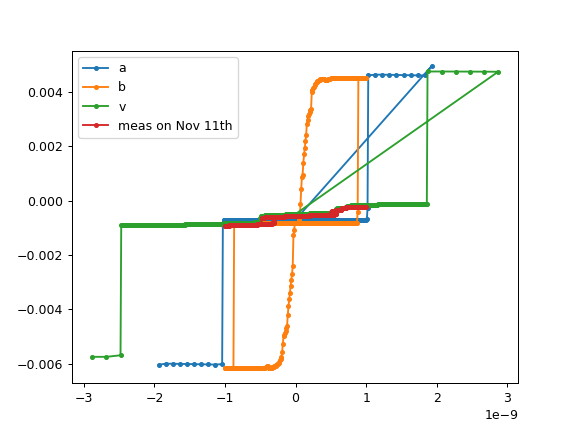

In [40]:
# Quick visualization of the results

qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format('70B1N7')
initialise_database()
f,ax=plt.subplots()

label = ['a',
         'b',
         'v',
         'meas on Nov 11th']

for i,v in enumerate([105, 971,1092,1095]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    ax.plot(Is, Vs, '.', ls='-',label = '{}'.format(label[i]))

ax.legend()

## Devices

### Device detail

- ID: aka05BN1 (slot 5B, Meander)  Room-T electrical performance
 - Up: (1ab,3b2a), $R_{RT, 4pb} = 267.1k\Omega$
 - Mi: (1ab,2a2b), $R_{RT, 4pb} = 275.7k\Omega$
 - Do: (1ab,2b3a), $R_{RT, 4pb} = 326.5k\Omega$

- ID: aka05BN8 (slot 5B, Hall-bar)  Room-T electrical performance
 - Up: (12ab,9b11b), $R_{RT, 4pb} = 5.6k\Omega$
 - Mi: (12ab,9a9b), $R_{RT, 4pb} = 5.8k\Omega$
 - Do: (12ab,11a9a), $R_{RT, 4pb} = 5.7k\Omega$
 
- ID: aka06BN8 (slot 6B, Hall-bar)  Room-T electrical performance
 - Up: (7b6a,7b4a), $R_{RT, 4pb} = 5.1k\Omega$
 - Mi: (7b6a,4a4b), $R_{RT, 4pb} = 3.2k\Omega$
 - Do: (7b6a,4b5b), $R_{RT, 4pb} = 3.4k\Omega$

- Device scheme
 - Meander segment: width $0.50\mu m$, total length $5x2x5\mu m$, 100 squares
 - Hall bar segment: width $0.5\mu m$, length $19\mu m$, 38 squares
 
Setup
 - $R_{G, 2pb}$ = OVFL on all devices
 - $R_{coil} = 1.24k\Omega$
 - $R_{therm} = 1.056k\Omega$

Sample label conversion
- I picked chips from slot 5B & 6B, this is marked as D?? and D??

### Biasing scheme

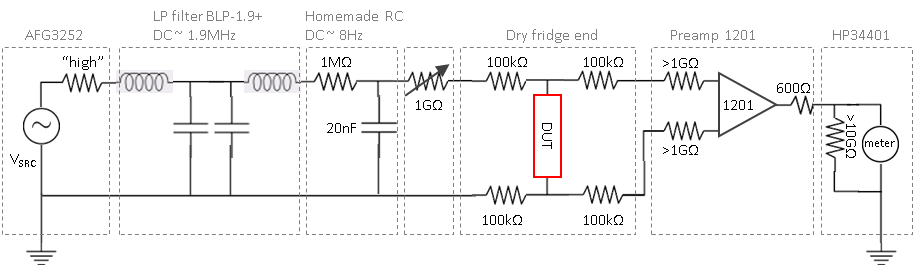

In [20]:
display(Image(filename=r'C:\Users\KelvinOX25\Documents\GitHub\DC meas\img\191026-183349.png'))

### Device quick overview

N3 **(low Z_env)**
RN=165E3/8, JJwidthUM=sqrt(0.2205*.17325), metalTHK=250E-10, Tc=1.34
[RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [20.625, 0.98947]
[I_AB (nA), EJ (mK)] = [15.51322, 369.78959]
[C_JJQP (fF), EC (mK)] = [1.91008, 486.6938]
[C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
[Freq_plasma (GHz))] = [1.60569]
[Q, Beta, EJ/EC] = [96.4, 9286.2, 184.2]

RRR(RT/10K) = 0.874

In [1]:
# display(Image(filename=r'\\JOSH-PC\OurData_OneDrive\img\70B1\N3.jpg'))

In [59]:
# N3
# qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\191102-70N3_IV300K-124250.txt')

## Measurement

### List of run_ids

#012-084: fussing around IVcB periodicity
#084-104: fussing around IVcB periodicity, part B
#105-205: BT = 40mK
#208-292: BT = 50mK, Blist = np.linspace(ZF,Zf = dFx1.1,101)[:-20] 
#296-346:  70mK, Blist = np.linspace(0,2e-3,51)
#450-500: 110mK, Blist = np.linspace(0,2e-3,51)
#501-551: 130mK, Blist = np.linspace(0,2e-3,51)

old
#073-173: IVC for T=45mK, Blist = np.linspace(0,2e-3,101), Vthr = 4mV
#174-228: IVC for T=45mK, Blist = np.linspace(0,2e-3,51), Vthr = 8mV
#229,230: Full IVC for T=80mK, Blist = [ZF,FF]
#231,232: Full IVC for T=100mK, Blist = [ZF,FF]
#233,234: Full IVC for T=125mK, Blist = [ZF,FF]
#236,237: Full IVC for T=150mK, Blist = [ZF,FF]
#238,239: Full IVC for T=175mK, Blist = [ZF,FF]
#246-297: IVC for T=200mK, Blist = np.linspace(0e-3, 2e-3, 51), Vthr = 4mV
#300-305: Full IVC for T=200mK, Blist = np.linspace(1e-3, 2e-3, 6), Vthr = 8mV
#306-356: IVC for T=300mK, Blist = np.linspace(0e-3, 2e-3, 51), Vthr = 4mV
#357-359: check full frustration periodicity
#360-410: IVC for T=350mK, Blist = np.linspace(0e-3, 2e-3, 51), Vthr = 4mV
#411-421: Full IVC for T=350mK, Blist = np.linspace(1e-3, 2e-3, 11), Vthr = 8mV
#422-432: Full IVC for T=400mK, Blist = np.linspace(1e-3, 2e-3, 11), Vthr = 8mV



In [156]:

dF = 0.250e-3
midF = 0.154e-3


keys  = ['ids',                  'T',          'B',                                          'Vthr']
valss = [[range(105, 205+1)[:],   45e-3,       np.linspace(ZF, ZF + 1.1*dF, 101)[:],         4e-3],
         [range(208, 292+1)[:],   50e-3,       np.linspace(ZF, ZF + 1.1*dF, 101)[:-16],      4e-3]
         [range(296, 346+1)[:],   70e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            4e-3],
         [range(347, 397+1)[:],   90e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            4e-3],
         [range(398, 448+1)[:],  110e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            4e-3],
         [range(450, 500+1)[:],  110e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            3e-3],
         [range(501, 551+1)[:],  130e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            3e-3],
         [range(552, 602+1)[:],  150e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            3e-3],
         [range(603, 653+1)[:],  170e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            3e-3],
         [range(654, 704+1)[:],  190e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            3e-3],
         [range(705, 755+1)[:],  210e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            3e-3],
         [range(758, 808+1)[:],  230e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            3e-3],
         

        ]  
        

ZF =  0.004e-3
FF =  0.224e-3
    
exps = [{ key : val for key, val in zip(keys, vals)  }  for vals in valss ]

### Plans and list of ToDo-es

**Plan**
- 
- 


**Selected meas to be done**
- 
- 

## Key observations

## Brief summary

### Meas at Room-T

In [227]:
SAMPLE = 'aka6bN8'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()

In [187]:
amp = 1000e-12
stp = 100e-12

IVC_udu (amp = 1000e-12, stp = 100e-12, Gain = 100, R_bias = 1e9, Attn = 1, tfsstb = 0.1)

Starting experimental run with id: 4



4

In [19]:
# time.sleep(40*60)
RTc(dataPts = 1e5, Gain = 100, R_bias = 1e9, Attn = 1, tfsstb = 0.1, I_bias = 0.4e-9)

NameError: name 'Vmeter' is not defined

## Device: aka5bN8

<IPython.core.display.Javascript object>


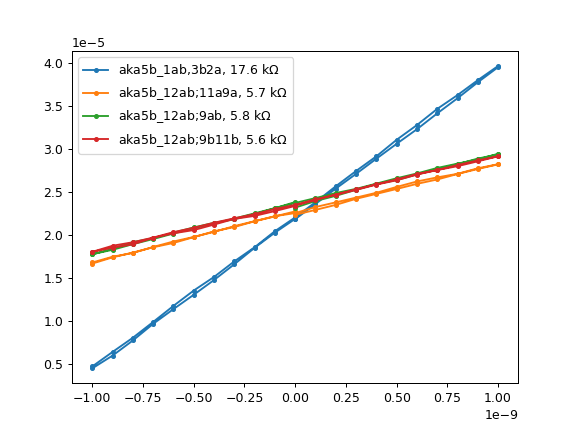

In [16]:
SAMPLE = 'aka5b' # N8, Hall bar structure
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots()
label = [SAMPLE + '_1ab,3b2a',
         SAMPLE + '_12ab;11a9a',
         SAMPLE + '_12ab;9ab',
         SAMPLE + '_12ab;9b11b']

for i,v in enumerate([3,4,5,6]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax.plot(Is, Vs, '.', ls='-',label = label[i]+', {}$\Omega$'.format(si_format(slope)))

ax.legend()
ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

<IPython.core.display.Javascript object>


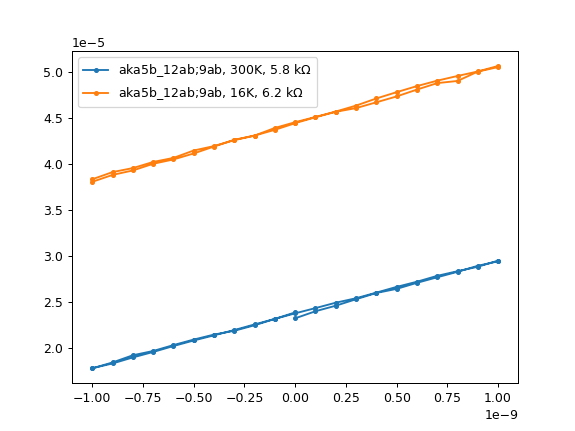

In [17]:
SAMPLE = 'aka5b' # N8, Hall bar structure
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots()
label = [SAMPLE + '_12ab;9ab, 300K',
         SAMPLE + '_12ab;9ab, 16K']

for i,v in enumerate([5,7]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax.plot(Is, Vs, '.', ls='-',label = label[i]+', {}$\Omega$'.format(si_format(slope)))

ax.legend()
ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

<IPython.core.display.Javascript object>


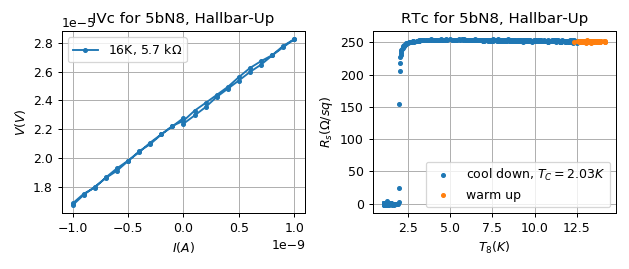

In [50]:
SAMPLE = 'aka5b'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 0.65e-6, 16e-6, 40e-9

labelL = [#'300K',
          '16K']
for i,v in enumerate([4]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].title.set_text('IVc for 5bN8, Hallbar-Up')
ax[0].grid()
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

labelR = [#'from 300K',
          'cool down, $T_C = 2.03K$',
          'warm up']
for i,v in enumerate([16,15]):
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.', label = labelR[i])#ls='-', 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].title.set_text('RTc for 5bN8, Hallbar-Up')
ax[1].grid()
ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


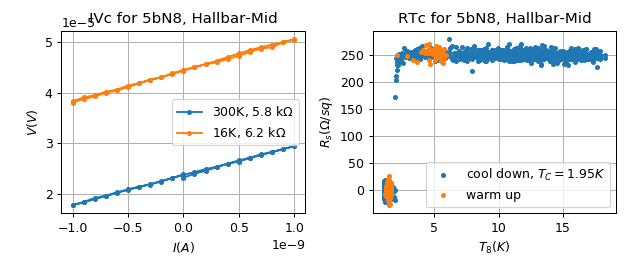

In [51]:
SAMPLE = 'aka5b'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 0.65e-6, 16e-6, 40e-9

labelL = ['300K',
          '16K']
for i,v in enumerate([5,7]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].title.set_text('IVc for 5bN8, Hallbar-Mid')
ax[0].grid()
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

labelR = [#'from 300K',
          'cool down, $T_C = 1.95K$',
          'warm up']
for i,v in enumerate([11,13]):
    data = get_data_by_id(v)
    T = data[0][0]['data'][:-5]
    R = data[0][1]['data'][:-5]
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.', label = labelR[i])#ls='-', 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].title.set_text('RTc for 5bN8, Hallbar-Mid')
ax[1].grid()
ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


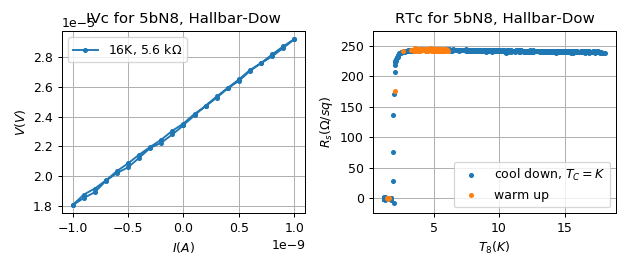

In [54]:
SAMPLE = 'aka5b'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 0.65e-6, 16e-6, 40e-9

labelL = [#'300K',
          '16K']
for i,v in enumerate([6]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].title.set_text('IVc for 5bN8, Hallbar-Dow')
ax[0].grid()
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

labelR = [#'from 300K',
          'cool down, $T_C = K$',
          'warm up']
for i,v in enumerate([20,19]):
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.', label = labelR[i])#ls='-', 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].title.set_text('RTc for 5bN8, Hallbar-Dow')
ax[1].set_ylim(-25,275)
ax[1].grid()
ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


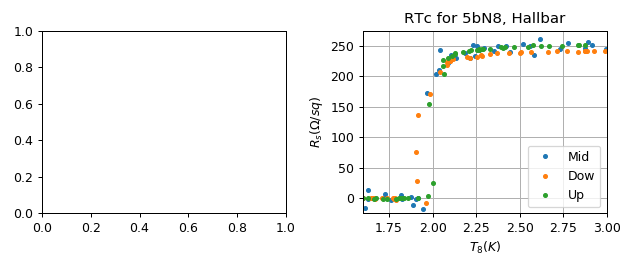

In [53]:
SAMPLE = 'aka5b'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 0.65e-6, 16e-6, 40e-9

labelR = ['Mid',
          'Dow',
          'Up' ]
for i,v in enumerate([11,20,16]):#27,
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.', label = labelR[i])#ls='-', 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].title.set_text('RTc for 5bN8, Hallbar')
ax[1].set_xlim(1.6,3)
ax[1].set_ylim(-25,275)
ax[1].grid()
# ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

plt.tight_layout()

## Device: aka5bN1

<IPython.core.display.Javascript object>


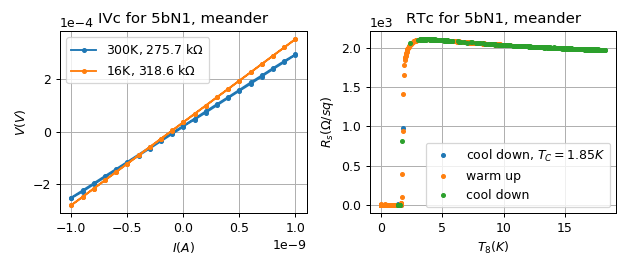

In [47]:
SAMPLE = 'aka5bN1'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devh, devl, devs, devTHK = 0.35e-6, 5e-6, 5e-6, 0.1e-6, 40e-9
devL = (devh+devs)*np.floor(devl/(devW+devs))

labelL = ['300K',
          '16K']
for i,v in enumerate([2,28]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].title.set_text('IVc for 5bN1, meander')
ax[0].grid()
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

labelR = [#'from 300K',
          'cool down, $T_C = 1.85K$',
          'warm up',
          'cool down']
for i,v in enumerate([35,41,42]):#27,
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.', label = labelR[i])#ls='-', 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].title.set_text('RTc for 5bN1, meander')
ax[1].grid()
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


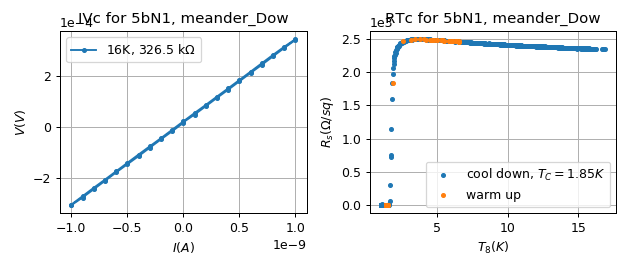

In [48]:
SAMPLE = 'aka5bN1'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devh, devl, devs, devTHK = 0.35e-6, 5e-6, 5e-6, 0.1e-6, 40e-9
devL = (devh+devs)*np.floor(devl/(devW+devs))

labelL = [#'300K',
          '16K']
for i,v in enumerate([3]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].title.set_text('IVc for 5bN1, meander_Dow')
ax[0].grid()
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

labelR = [#'from 300K',
          'cool down, $T_C = 1.85K$',
          'warm up',
          'warm up']
for i,v in enumerate([45,44]):#27,
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.', label = labelR[i])#ls='-', 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].title.set_text('RTc for 5bN1, meander_Dow')
ax[1].grid()
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


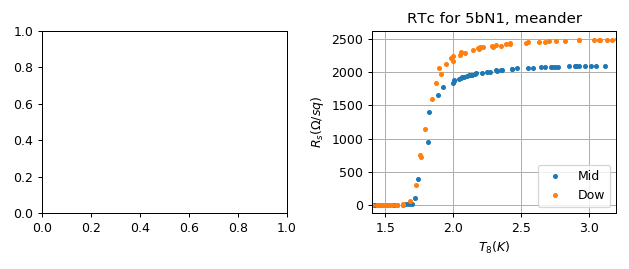

In [49]:
SAMPLE = 'aka5bN1'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devh, devl, devs, devTHK = 0.35e-6, 5e-6, 5e-6, 0.1e-6, 40e-9
devL = (devh+devs)*np.floor(devl/(devW+devs))

labelR = ['Mid',
          'Dow']
for i,v in enumerate([41,45]):#27,
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.', label = labelR[i])#ls='-', 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].title.set_text('RTc for 5bN1, meander')
ax[1].set_xlim(1.4,3.2)
ax[1].grid()
# ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


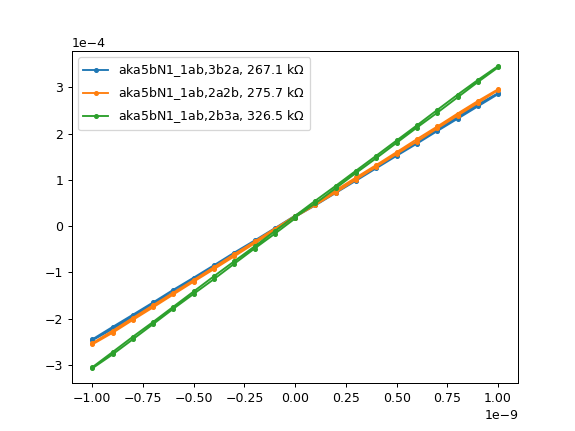

In [41]:
SAMPLE = 'aka5bN1'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots()
label = [SAMPLE + '_1ab,3b2a',
         SAMPLE + '_1ab,2a2b',
         SAMPLE + '_1ab,2b3a']#,
#          SAMPLE + '_1ab,2a2b']

for i,v in enumerate([1,2,3]):#,4
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax.plot(Is, Vs, '.', ls='-',label = label[i]+', {}$\Omega$'.format(si_format(slope)))

ax.legend()
ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

<IPython.core.display.Javascript object>


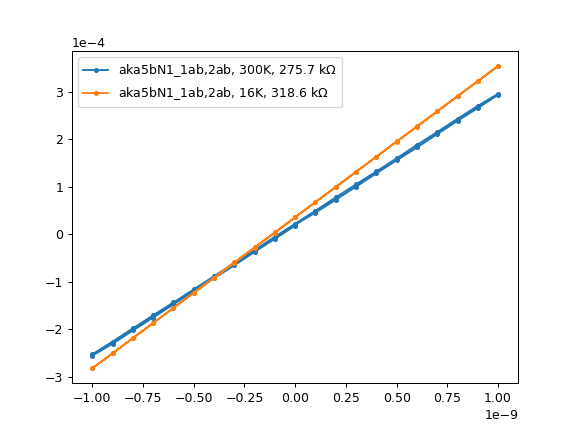

In [189]:
SAMPLE = 'aka5bN1'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots()
label = [SAMPLE + '_1ab,2ab, 300K',
         SAMPLE + '_1ab,2ab, 16K']

for i,v in enumerate([2,28]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax.plot(Is, Vs, '.', ls='-',label = label[i]+', {}$\Omega$'.format(si_format(slope)))

ax.legend()
ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

<IPython.core.display.Javascript object>


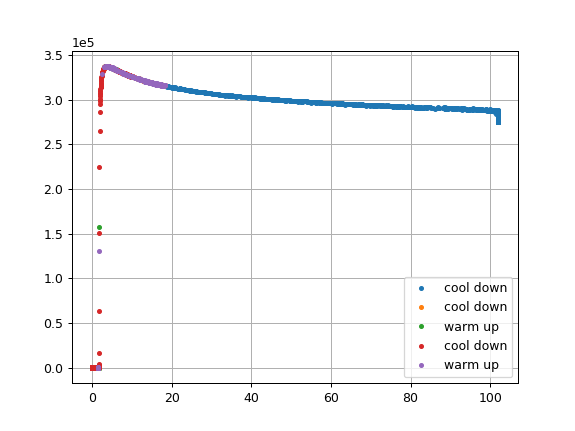

In [58]:
import qcodes as qc
from qcodes.dataset.database import initialise_database
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
import matplotlib.pyplot as plt
import numpy as np

SAMPLE = 'aka5bN1'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots()
label = ['cool down',
         'cool down',
         'warm up',
         'cool down',
         'warm up']

for i,v in enumerate([27,32,35,41,42]):#,32
    data = get_data_by_id(v)
    T = data[0][0]['data']
#     T = np.linspace(1,len(data[0][0]['data']),len(data[0][0]['data']))
    R = data[0][1]['data']

    ax.plot(T, R, '.', label = label[i])#ls='-', 

ax.legend()
ax.grid()
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

## Device: aka6bN8

<IPython.core.display.Javascript object>


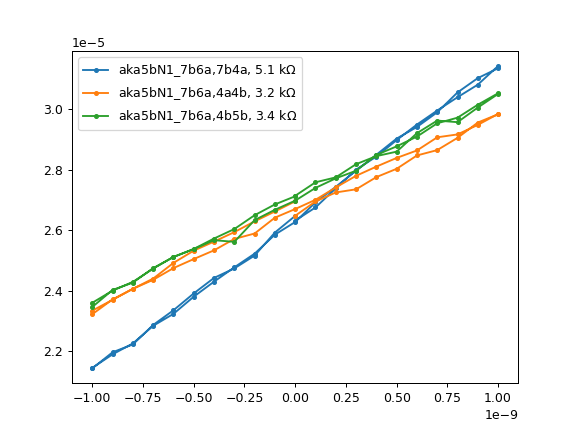

In [93]:
SAMPLE = 'aka6bN8'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots()
label = [SAMPLE + '_7b6a,7b4a',
         SAMPLE + '_7b6a,4a4b',
         SAMPLE + '_7b6a,4b5b']

for i,v in enumerate([1,2,3]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax.plot(Is, Vs, '.', ls='-',label = label[i]+', {}$\Omega$'.format(si_format(slope)))

ax.legend()
ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

<IPython.core.display.Javascript object>


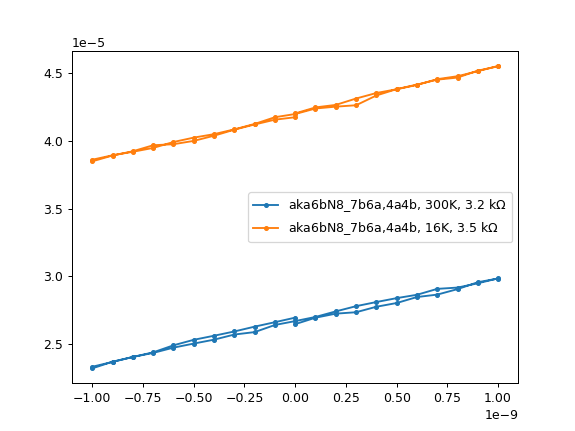

In [190]:
SAMPLE = 'aka6bN8'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots()
label = [SAMPLE + '_7b6a,4a4b, 300K',
         SAMPLE + '_7b6a,4a4b, 16K']

for i,v in enumerate([2, 4]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax.plot(Is, Vs, '.', ls='-',label = label[i]+', {}$\Omega$'.format(si_format(slope)))

ax.legend()
ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

<IPython.core.display.Javascript object>


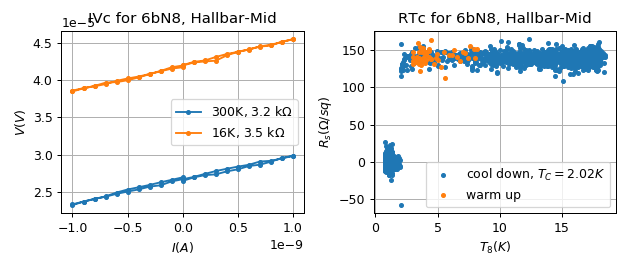

In [55]:
SAMPLE = 'aka6bN8'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 0.65e-6, 16e-6, 40e-9

labelL = ['300K',
          '16K']
for i,v in enumerate([2,4]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].title.set_text('IVc for 6bN8, Hallbar-Mid')
ax[0].grid()
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

labelR = [#'from 300K',
          'cool down, $T_C = 2.02K$',
          'warm up']
for i,v in enumerate([6,5]):
    data = get_data_by_id(v)
    T = data[0][0]['data'][:-2]
    R = data[0][1]['data'][:-2]
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.', label = labelR[i])#ls='-', 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].title.set_text('RTc for 6bN8, Hallbar-Mid')
ax[1].grid()
ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


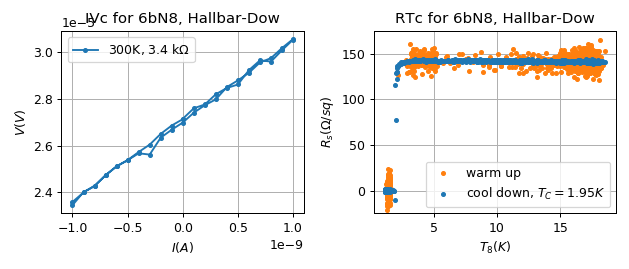

In [56]:
SAMPLE = 'aka6bN8'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 0.65e-6, 16e-6, 40e-9

labelL = ['300K']
#           ,
#           '16K']
for i,v in enumerate([3]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].title.set_text('IVc for 6bN8, Hallbar-Dow')
ax[0].grid()
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

labelR = [#'from 300K',
          'warm up',
          'cool down, $T_C = 1.95K$']
for i,v in enumerate([7,8]):
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.', label = labelR[i], color = 'C{}'.format(1-i))#ls='-', alpha=1-0.99*i 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].title.set_text('RTc for 6bN8, Hallbar-Dow')
ax[1].set_ylim(-25,175)
ax[1].grid()
ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


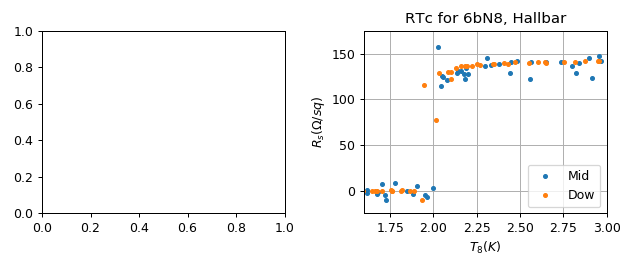

In [57]:
SAMPLE = 'aka6bN8'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 0.65e-6, 16e-6, 40e-9

labelR = ['Mid',
          'Dow']
for i,v in enumerate([6,8]):#27,
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.', label = labelR[i])#ls='-', 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].title.set_text('RTc for 6bN8, Hallbar')
ax[1].set_xlim(1.6,3)
ax[1].set_ylim(-25,175)
ax[1].grid()
# ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

plt.tight_layout()

### Efficient thermal cycling

After studying T response, I summary below process:
1. Warming up takes about 50min, on the scale at the dump we will see almost full collection. During this period T6 was kept at 1.5K, and all of a sudden (within 2min window) it went up to 5K.
2. Cooling back to T1~60K takes about 1hr (might be less tho, since T2,T5,T6 cool back to <10K within 10min)
3. PPC takes about 1hr30min, plus 20min settling down. During this period we expect to see T2 and T6 ~12K while T5 ~20K.
4. after PPC let's try to wait minimal time before start condensation
5. The condensation process can be interrupted after 2hr30min, where T5,T6,T8 ~ 0.9K and turbo hasn't been ON yet.

- mixture collection: 50min
- cooling back to 8K: 20min
- change leads
- Pulse-pre-cooling : 1hr30min
- Settling cooling  : 30min
- Condense with LN2 : 2hr30min

<IPython.core.display.Javascript object>


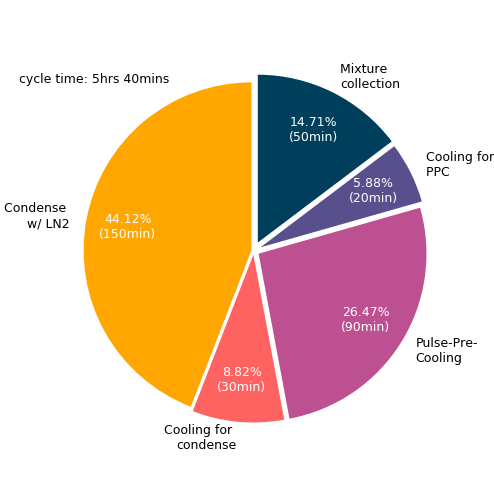

In [12]:
def min2hr(time='1hr20min'):
    hr, minu = time.split('hr')[0], time.split('hr')[1][:-3]
    return int(hr)*60+int(minu)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d}min)'.format(p=pct,v=val)
    return my_autopct


labels = ['Mixture \ncollection', 
          'Cooling for \nPPC ', 
          'Pulse-Pre-\nCooling',
          'Cooling for \ncondense',
          'Condense \nw/ LN2']

sizes =  [min2hr('0hr50min'), 
          min2hr('0hr20min'), 
          min2hr('1hr30min'), 
          min2hr('0hr30min'), 
          min2hr('2hr30min')]

colors = [[0    , 0.247, 0.361], 
          [0.345, 0.314, 0.553], 
          [0.737, 0.314, 0.565], 
          [1    , 0.388, 0.38 ],
          [1    , 0.651, 0    ]]

# colors = [[230/255, 97/255,  1/255],
#           [253/255,184/255, 99/255],
#           [247/255,247/255,247/255],
#           [178/255,171/255,210/255],
#           [ 94/255, 60/255,153/255]]
#http://colorbrewer2.org/#type=diverging&scheme=PuOr&n=5

expldlst = np.array([])
for i in range(5):
    expldlst = np.append(expldlst, (1.35-i*0.25)/25)
explode = expldlst

plt.close('all')
_, _, autotexts = plt.pie(sizes, explode = explode, labels = labels, colors = colors, shadow = False,
                          autopct = make_autopct(sizes), startangle = 90, counterclock = False,
                          pctdistance=0.75, labeldistance=1.1)
for autotext in autotexts:
    autotext.set_color('white')

# '%1.1f%%'
plt.axis('equal')
plt.text(-1.4,1,'cycle time: {}hrs {}mins'.format(int(np.floor(sum(sizes)/60)), 
                                                  np.remainder(sum(sizes),60)))
fig = plt.gcf()
fig.set_size_inches(5.5,5.5)
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# plt.rc('font', **font)
plt.show()

<IPython.core.display.Javascript object>


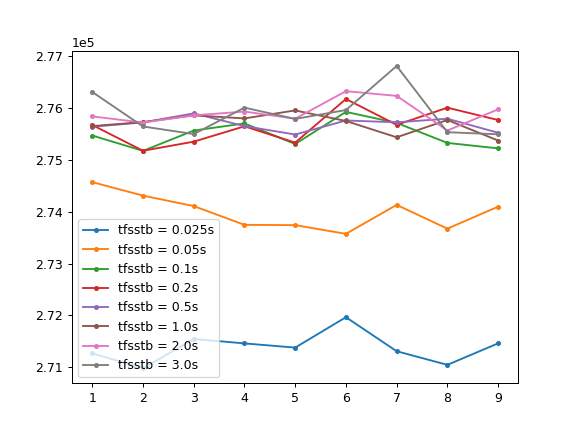

In [137]:
# tfsstb setting from RTc measurement
SAMPLE = 'aka5bN1'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots()
tlst = [0.025, 0.050, 0.100, 0.200, 0.500, 1.000, 2.000, 3.000]
labellst = []
for t in tlst:
    labellst = np.append(labellst, 'tfsstb = {}s'.format(t))

for i,v in enumerate([10,11,12,13,14,15,16,17]):
    data = get_data_by_id(v)
#     T = data[0][0]['data']
    T = np.linspace(1,len(data[0][0]['data']),len(data[0][0]['data']))
    R = data[0][1]['data']
    ax.plot(T, R, '.', ls='-',label = labellst[i])

ax.legend()
ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))